# Working with automated computations: Imported tables

Welcome back! In this session, we are going to continue working with the pipeline for the mouse electrophysiology example. 

In this session, we will learn to:

* import neuron activity data from data files into an `Imported` table
* automatically trigger computations for all missing entries with `populate`

First thing first, let's import `datajoint` again.

In [1]:
import datajoint as dj

As we are going to perform some computations, let's go ahead and import NumPy as well as Matplotlib.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Now we would like to continue working with the tables we defined in the previous notebook. To do so, we would need the classes for each table: `Mouse` and `Session`. We can either redefine it here, but for your convenience, we have included the schema and table class definitions in a package called `tutorial_pipeline.mouse_session`, from which you can import the classes as well as the schema object. We will use the schema object again to define more tables.

In [3]:
from tutorial_pipeline.mouse_session import schema, Mouse, Session

Please enter DataJoint username: root
Please enter DataJoint password: ········
Connecting root@localhost:3306


In [4]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
1,2016-11-19,M
2,2016-11-20,unknown
5,2016-12-25,F
10,2017-01-01,F
11,2017-01-03,F
100,2017-05-12,F


In [5]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2017-05-15,0,Edgar Y. Walker,
0,2017-05-19,0,Edgar Y. Walker,
5,2017-01-05,1,Fabian Sinz,
100,2017-05-25,100,Jacob Reimer,


The `mouse_session.py` also fills each table with data to make sure we are all on the same page.

## Importing data from data files

Recall from the project description
> * In each experimental session, you record electrical activity from a single neuron. You use recording equipment that produces separate data files for each neuron you recorded.

Our recording equipment produces a data file for each neuron recorded. Since we record from one neuron per session, there should be one data file for each session.

In the `data` directory, you will find `.npy` (saved NumPy array) files with names like `data_100_2017-05-25.npy`.

As you might have guessed, these are the data for the recording sessions in the `Session` table, and each file are named according to the `mouse_id` and `session_date` - the attributes of the primary keys - in the format `data_{mouse_id}_{session_date}.npy`.

So `data_100_2017-05-25.npy` is the data for session identified by `mouse_id = 100` and `session_date = "2017-05-25"`.

In [ ]:
from tutorial_pipeline import data_dir

data_dir

## Looking at the data 

Let's take a quick peak at the data file content.

First, let's pick a session to load the data for. To do this we are going to first fetch the **primary key attributes** of `Session` as a list of dictionaries. We make use of the special `fetch('KEY')` syntax to achieve this.

In [6]:
keys = Session.fetch("KEY")
keys

[{'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15)},
 {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19)},
 {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5)},
 {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25)}]

Any item in this list of keys can be used to uniquely identify a single session!

In [7]:
# ENTER YOUR CODE! - restrict session by an element of keys
Session & keys[1]

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2017-05-19,0,Edgar Y. Walker,


Let's take the first key, and generate the file name that corresponds to this session. Remember the `data_{mouse_id}_{session_date}.npy` filename convention!

In [8]:
key = keys[0]
key

{'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15)}

In [9]:
filename = "{data_dir}/data_{mouse_id}_{session_date}.npy".format(
    **key, data_dir=data_dir
)
filename

'data/data_0_2017-05-15.npy'

Here we have made use of Python's dictionary unpacking and `format` method on strings to generate the filename from the `key`.

Finally, let's load the file.

In [10]:
data = np.load(filename)

Look at its content...

In [11]:
data

array([[ 3.57887412e-01,  4.47531558e-01,  1.96412988e-01,
         3.91114491e-01,  1.76695176e-01,  3.80088116e-01,
         9.36353656e-02,  1.10668001e-02,  1.14509759e-01,
         1.65947705e-01,  1.02058476e-01,  1.15037690e-01,
         2.18115225e-01,  1.34076355e-01,  7.74560696e-02,
         9.19639027e-02, -7.60109670e-03,  1.12814011e+00,
         9.48711628e-01,  7.77781245e-01,  5.46847747e-01,
         3.91930226e-01,  2.19542222e-01,  3.92001858e-01,
         3.17729202e-01,  2.97934834e-01,  1.85589403e-01,
         3.04215179e-01,  8.75626287e-02, -1.76018214e-02,
         1.43719730e-01, -1.28348781e-01, -4.38344653e-02,
         1.57370375e-01,  1.70233992e-01,  8.98556797e-01,
         9.36896773e-01,  1.67418776e+00,  2.48160598e+00,
         1.89737445e+00,  1.45746470e+00,  1.32137967e+00,
         1.05349900e+00,  1.88503636e+00,  1.53324759e+00,
         1.34566597e+00,  1.93924029e+00,  1.58839106e+00,
         1.26074176e+00,  1.21973014e+00,  9.80495008e-0

...and check the shape of the data.

In [12]:
data.shape

(1, 1000)

So this particular file contains a NumPy array of size 1 x 1000. This represents a (simulated) recording of raw electric activity from neuron(s) (1st dimension) over 1000 time bins (2nd dimension).

## Defining the table for recorded neurons

We now would like to have all these recorded `Neuron` represented and stored in our data pipeline.

Since there may be multiple neurons recorded from each session, a `Neuron` can be uniquely identified by knowing the `Session` it was recorded in, as well as its `neuron_id`. For each `Neuron`, we want to store the neural activity found in the data file.

In [13]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    neuron_id: int
    ---
    activity: longblob    # electric activity of the neuron
    """

Let's check the state of our pipeline.

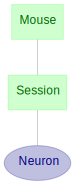

In [14]:
# ENTER YOUR CODE! - plot Diagram of the schema
dj.Diagram(schema)

We defined `activity` as a `longblob` so that it can store a NumPy array holding the electric activity over time. This NumPy array will be imported from the file corresponding to each neuron.

Note that our `Neuron` class inherits from `dj.Imported` instead of `dj.Manual` like others. This is because **this table's content will depend on data imported from an external file**. The `Manual` vs `Imported` are said to specify the **tier of the table**.

## DataJoint table tiers

In DataJoint, the tier of the table indicates **the nature of the data and the data source for the table**. So far we have encountered two table tiers: `Manual` and `Imported`, and we will encounter the two other major tiers in this session. 

DataJoint tables in `Manual` tier, or simply **Manual tables** indicate that its contents are **manually** entered by either experimenters or a recording system, and its content **do not depend on external data files or other tables**. This is the most basic table type you will encounter, especially as the tables at the beginning of the pipeline. In the Diagram, `Manual` tables are depicted by green rectangles.

On the other hand, **Imported tables** are understood to pull data (or *import* data) from external data files, and come equipped with functionalities to perform this importing process automatically, as we will see shortly! In the Diagram, `Imported` tables are depicted by blue ellipses.

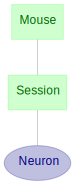

In [15]:
dj.Diagram(schema)

## Importing data into the `Imported` table

Rather than filling out the content of the table manually using `insert1` or `insert` methods, we are going to make use of the `make` and `populate` logic that comes with `Imported` tables to automatically figure out what needs to be imported and perform the import!

## `make` and `populate` methods

`Imported` table comes with a special method called `populate`. Let's try calling it.

In [16]:
# ENTER YOUR CODE! - call `populate` on the table
Neuron.populate()

NotImplementedError: Subclasses of AutoPopulate must implement the method `make`

Notice that `populate` call complained that a method called `make` is not implemented. Let me show a simple `make` method that will help elucidate what this is all about.

In [17]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    neuron_id: int
    ---
    activity: longblob    # electric activity of the neuron
    """

    def make(self, key):  # `make` takes a single argument `key`
        print("key is", key)

Now, let's call `populate` again!

In [18]:
# ENTER YOUR CODE! - call `populate` on the table
Neuron.populate()

key is {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15)}
key is {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19)}
key is {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5)}
key is {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25)}


When you call `populate` on an `Imported` table, this triggers DataJoint to look up all tables that the `Imported` table depends on.

For **every unique combination of entries in the depended or "parent" tables**, DataJoint calls `make` function, passing in the primary key of the parent(s).

Because `Neuron` depends on `Session`, `Neuron`'s `make` method was called for each entry of `Session`

In [19]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2017-05-15,0,Edgar Y. Walker,
0,2017-05-19,0,Edgar Y. Walker,
5,2017-01-05,1,Fabian Sinz,
100,2017-05-25,100,Jacob Reimer,


Note that `make` only receives the *primary key attributes* of `Session` (`mouse_id` and `session_date`) but not the other attributes.

## Implementing `make`

Now we have a better understanding of `make`, let's implement `make` to perform the importing of data from file.

In [20]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    neuron_id: int
    ---
    activity: longblob    # electric activity of the neuron
    """

    def make(self, key):
        # use key dictionary to determine the data file path
        data_file = "{data_dir}/data_{mouse_id}_{session_date}.npy".format(
            **key, data_dir=data_dir
        )

        # load the data
        data = np.load(data_file)

        print(
            "Populating neuron(s) for mouse_id={mouse_id} on session_date={session_date}".format(
                **key
            )
        )
        for idx, d in enumerate(data):
            # add the index of the 1st dimension as neuron_id
            key["neuron_id"] = idx

            # add the loaded data as the "activity" column
            key["activity"] = d

            # insert the key into self
            self.insert1(key)

            print("\tPopulated neuron {neuron_id}".format(**key))

Notice that we added the missing attribute information `activity` into the `key` dictionary, and finally **inserted the entry** into `self` = `Neuron` table. The `make` method's job is to create and insert a new entry corresponding to the `key` into this table!

Finally, let's go ahead and call `populate` to actually populate the `Neuron` table, filling it with data loaded from data files!

In [21]:
Neuron.populate()

Populating neuron(s) for mouse_id=0 on session_date=2017-05-15
	Populated neuron 0
Populating neuron(s) for mouse_id=0 on session_date=2017-05-19
	Populated neuron 0
Populating neuron(s) for mouse_id=5 on session_date=2017-01-05
	Populated neuron 0
Populating neuron(s) for mouse_id=100 on session_date=2017-05-25
	Populated neuron 0


In [22]:
Neuron()

mouse_id Unique animal ID,session_date date,neuron_id,activity electric activity of the neuron
0,2017-05-15,0,=BLOB=
0,2017-05-19,0,=BLOB=
5,2017-01-05,0,=BLOB=
100,2017-05-25,0,=BLOB=


As you can obviously see, in these example datasets, we only have data for one neuron per session. 

What happens if we call `Neuron.populate` again?

In [23]:
Neuron.populate()

That's right - nothing! This makes sense, because we have imported `Neuron` for all entries in `Session` and nothing is left to be imported.

Now what happens if we insert a new entry into `Session`?

In [24]:
Session.insert1(
    {
        "mouse_id": 100,
        "session_date": "2017-06-01",
        "experiment_setup": 1,
        "experimenter": "Jacob Reimer",
    }
)

We can find all `Session` without corresponding `Neuron` entry with the **negative restriction operator** `-`

In [25]:
# select all Session entries *without* a corresponding entry in Neuron
Session - Neuron

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
100,2017-06-01,1,Jacob Reimer,


In [26]:
Neuron.populate()

Populating neuron(s) for mouse_id=100 on session_date=2017-06-01
	Populated neuron 0


In [27]:
Neuron()

mouse_id Unique animal ID,session_date date,neuron_id,activity electric activity of the neuron
0,2017-05-15,0,=BLOB=
0,2017-05-19,0,=BLOB=
5,2017-01-05,0,=BLOB=
100,2017-05-25,0,=BLOB=
100,2017-06-01,0,=BLOB=


## Summary

Congratulations! You have successfully extended your pipeline with a table to represent recorded data (`Neuron` as `Imported` table), learned and implemented the `make()` and `populate()` call to load external data to your tables.

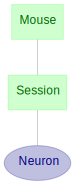

In [28]:
dj.Diagram(schema)

At this point, our pipeline contains the core elements with data populated, ready for further downstream analysis.

In the next session, we are going to introduce the concept of `Computed` table, and `Lookup` table, as well as learning to set up a automated computation routine.